<a href="https://colab.research.google.com/github/soumik12345/examples/blob/master/colabs/tensorflow/convert_imagenette_tfrecord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q wandb
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xzf imagenette2-320.tgz
!rm imagenette2-320.tgz

     |████████████████████████████████| 1.8 MB 7.8 MB/s 
     |████████████████████████████████| 181 kB 50.0 MB/s 
     |████████████████████████████████| 147 kB 43.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
--2022-07-20 14:45:27--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.81.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.81.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  45.0MB/s    in 7.9s    

2022-07-20 14:45:35 (41.0 MB/s) - ‘imagenette2-320.tgz’ saved [341663724/341663724]



In [ ]:
import os
import cv2
import math
import wandb
import random
import numpy as np
from glob import glob
from PIL import Image
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
LABEL_DICT = {
    "n01440764": ["tench", 0],
    "n02102040": ["english_springer", 1],
    "n02979186": ["cassette_player", 2],
    "n03000684": ["chain_saw", 3],
    "n03028079": ["church", 4],
    "n03394916": ["french_horn", 5],
    "n03417042": ["grabage_truck", 6],
    "n03425413": ["gas_pump", 7],
    "n03445777": ["golf_ball", 8],
    "n03888257": ["parachute", 9]
}

In [ ]:
wandb.init(
    project="simple-training-loop",
    entity="jax-series",
    job_type="tfrecord"
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def create_example(image_file, label):
    feature = {
        "image": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[tf.io.read_file(image_file).numpy()]
            )
        ),
        "label": tf.train.Feature(
            int64_list=tf.train.Int64List(value=[LABEL_DICT[label][1]])
        ),
        "label_name": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[LABEL_DICT[label][0].encode('utf8')]
            )
        )
    }
    return tf.train.Example(
        features=tf.train.Features(feature=feature)
    )

In [ ]:
train_images = glob(os.path.join("imagenette2-320", "train/*/*.JPEG"))
random.shuffle(train_images)
train_labels = [img.split("/")[-2] for img in train_images]

val_images = glob(os.path.join("imagenette2-320", "val/*/*.JPEG"))
random.shuffle(val_images)
val_labels = [img.split("/")[-2] for img in val_images]

In [ ]:
def chunkify(input_list, chunk_size):
    chunk_size = max(1, chunk_size)
    return [
        input_list[i: i + chunk_size]
        for i in range(0, len(input_list), chunk_size)
    ]


def create_tfrecords(images, labels, max_chunk_size: int, dump_dir: str):
    os.makedirs(dump_dir)
    num_chunks = math.ceil(len(images) / max_chunk_size)
    print("Total number of image-label pairs:", len(images))
    print("Total number of image-label pair chunks:", num_chunks)
    image_chunks = chunkify(images, max_chunk_size)
    label_chunks = chunkify(labels, max_chunk_size)
    table = wandb.Table(columns=[
        "Image", "Label-Name", "Label-ID", "Split-Name", "Chunk-ID"
    ])
    for idx in range(num_chunks):
        image_chunk = image_chunks[idx]
        label_chunk = label_chunks[idx]
        current_chunk_size = len(image_chunk)
        file_name = "%.2i-%.3i.tfrec" % (idx + 1, current_chunk_size)
        tfrecord_file = os.path.join(dump_dir, file_name)
        writer = tf.io.TFRecordWriter(tfrecord_file)
        progress_bar = tqdm(
            range(current_chunk_size),
            desc=f"Writing {file_name}"
        )
        for chunk_idx in progress_bar:
            image = Image.open(image_chunk[chunk_idx])
            table.add_data(
                wandb.Image(image),
                LABEL_DICT[label_chunk[chunk_idx]][0],
                LABEL_DICT[label_chunk[chunk_idx]][1],
                dump_dir.split("/")[-1],
                idx
            )
            example = create_example(
                image_chunk[chunk_idx], label_chunk[chunk_idx]
            )
            writer.write(example.SerializeToString())
        writer.close()
    return table

In [ ]:
print("Creating TFRecords for train data...")
train_table = create_tfrecords(
    train_images,
    train_labels,
    max_chunk_size=512,
    dump_dir="tfrecords/train"
)

print("Creating TFRecords for validation data...")
val_table = create_tfrecords(
    val_images,
    val_labels,
    max_chunk_size=512,
    dump_dir="tfrecords/val"
)

Creating TFRecords for train data...
Total number of image-label pairs: 9469
Total number of image-label pair chunks: 19


Writing 01-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 02-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 03-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 04-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 05-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 06-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 07-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 08-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 09-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 10-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 11-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 12-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 13-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 14-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 15-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 16-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 17-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 18-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 19-253.tfrec:   0%|          | 0/253 [00:00<?, ?it/s]

Creating TFRecords for validation data...
Total number of image-label pairs: 3925
Total number of image-label pair chunks: 8


Writing 01-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 02-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 03-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 04-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 05-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 06-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 07-512.tfrec:   0%|          | 0/512 [00:00<?, ?it/s]

Writing 08-341.tfrec:   0%|          | 0/341 [00:00<?, ?it/s]

In [ ]:
wandb.log({"Train-Data": train_table})
wandb.log({"Validation-Data": val_table})

In [ ]:
def parse_tfrecord(example):
    example = tf.io.parse_single_example(
        example, {
            "image": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.VarLenFeature(tf.int64),
            "label_name": tf.io.VarLenFeature(tf.string)
        }
    )
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["label"] = tf.sparse.to_dense(example["label"])
    example["label_name"] = tf.sparse.to_dense(example["label_name"])
    return example


raw_dataset = tf.data.TFRecordDataset(glob("./tfrecords/train/*"))
parsed_dataset = raw_dataset.map(parse_tfrecord)

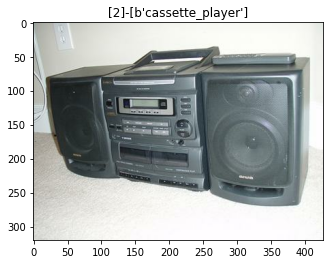

In [ ]:
for features in parsed_dataset.take(1):
    plt.imshow(features["image"].numpy())
    label = features["label"].numpy()
    label_name = features["label_name"].numpy()
    plt.title(f"{label}-{label_name}")
    plt.show()

In [ ]:
artifact = wandb.Artifact(
    'imagenette-tfrecords',
    type='dataset',
    metadata={
        "author": "Jeremy Howard",
        "title": "imagenette",
        "url": "https://github.com/fastai/imagenette/",
        "source": "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
    }
)
artifact.add_dir('tfrecords')
wandb.log_artifact(artifact, aliases=["320px"])

wandb: Adding directory to artifact (./tfrecords)... Done. 2.6s


In [ ]:
wandb.finish()